In [62]:
# imports
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_score, confusion_matrix
import warnings

In [8]:
df = pd.read_csv('C:\\Users\\souza\\OneDrive\\Área de Trabalho\\Risk Nubank\\data\\data_tratado.csv')
df.columns


Index(['Unnamed: 0', 'target_default', 'score_3', 'risk_rate', 'credit_limit',
       'income', 'n_defaulted_loans', 'n_issues', 'ok_since', 'n_bankruptcies',
       'score_rating', 'score_rating_enc', 'situation'],
      dtype='object')

In [9]:
# dropando algumas colunas 
drop_columns = ['Unnamed: 0', 'score_rating_enc' ]
df = df.drop(drop_columns, axis=1)

In [11]:
df['target_default'].value_counts()

target_default
0    34964
1     6642
Name: count, dtype: int64

In [12]:
# seleçao das variaveis 
x = df.drop('target_default', axis=1)
y = df['target_default']

In [14]:
# split train test 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(f'shape xtreino: {x_train.shape}, shape ytreino {y_train.shape}')
print(f'shape xteste {x_test.shape}, shape yteste {y_test.shape}')

shape xtreino: (33284, 10), shape ytreino (33284,)
shape xteste (8322, 10), shape yteste (8322,)


In [57]:
# funcao metrics 
def metrics(model, y_true, y_pred):
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    out = {
        'model_name':model.__class__.__name__,
        'acuracia':acc,
        'precisao': precision,
        'f1_score':f1,
        'recall': recall,
        'roc_auc': recall
        
    }
    return out

# funcao para plot de curva roc
def roc_curve_plot(y_true, y_proba, model):
    tpr, fpr, _ = roc_curve(y_score=y_proba, y_true=y_true)
    
    # plotandoo grafico
    plt.figure(figsize=(12,8))
    plt.title(f'roc curve modelo -{model.__class__.__name__}')
    plt.plot([0,1], [0,1], linestyle='--', color='black', label='coringa') # linha coringa = 0
    plt.plot(tpr, fpr,  label=model.__class__.__name__, color='purple')
    plt.xlabel('falsos positivos')
    plt.ylabel('verdadeiros postivos')
    plt.tight_layout()
    plt.grid()
    plt.legend()
    plt.show()
    
# funcao matriz de confusao 

def matrix(model, y_true, y_pred):
    plt.figure(figsize=(15,8))
    conf = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Negativo (prev)', 'Positivo (prev)'],
            yticklabels=['Negativo (real)', 'Positivo (real)'])
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title(f'Matriz de confusao modelo: {model.__class__.__name__}')
    plt.show()
    

In [26]:
# lista com modelos, random_state=42 para reprodutibilidade e class_weight='balanced' para penalizar o modelo por conta do desbalanceamento das classes
models = {
    'Regressao logistica':LogisticRegression(random_state=42, class_weight='balanced'),
    'Arvore de descisao':DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier()
}

In [18]:
# seleçao de atributos 
cat_atribs = ['score_rating', 'situation']
num_atribs = ['score_3', 'risk_rate', 'credit_limit', 'income', 'n_defaulted_loans', ' n_issues', 'ok_since',
            'n_bankruptcies', ' score_rating_enc']

In [24]:
# criaçao de columns transf e pipeline 
column_transf = ColumnTransformer([('onehot', OneHotEncoder(handle_unknown='ignore'), cat_atribs)
                                ])
pipe = Pipeline(steps=[('transformer', column_transf),
                    ('model', LogisticRegression())
                    ])

treinando modelo: LogisticRegression


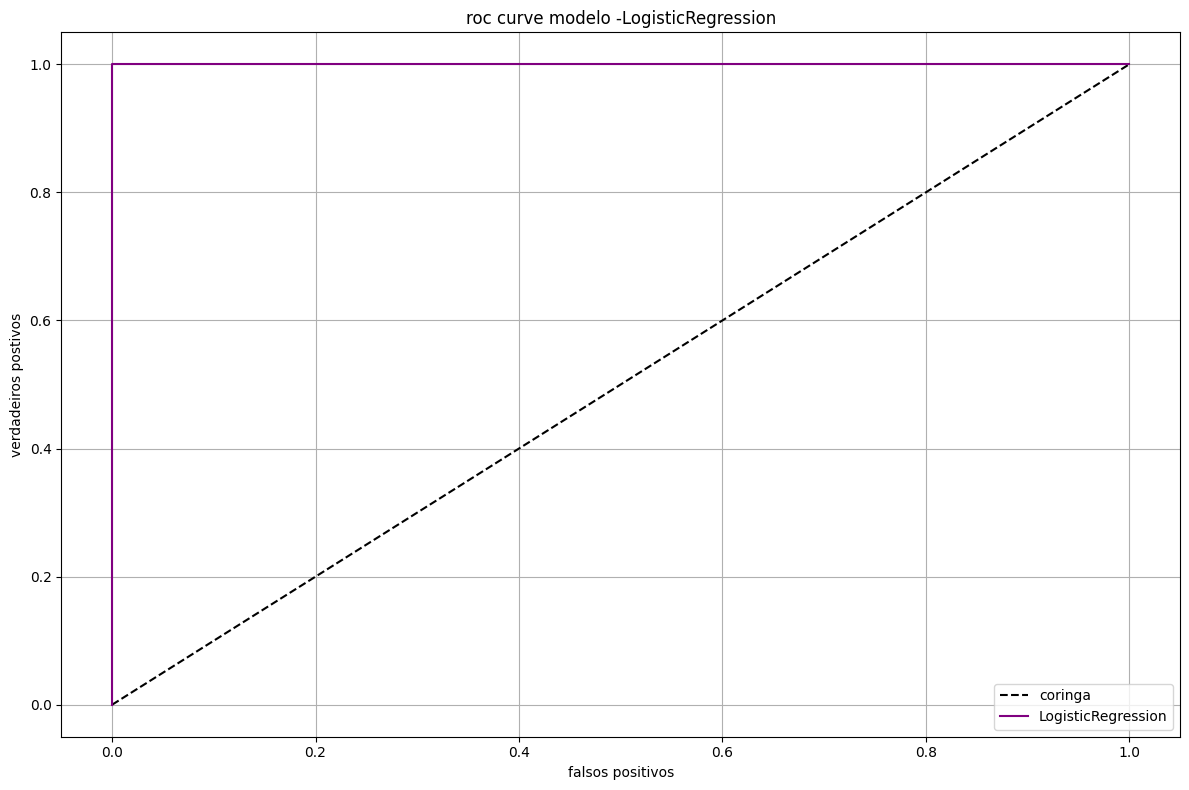

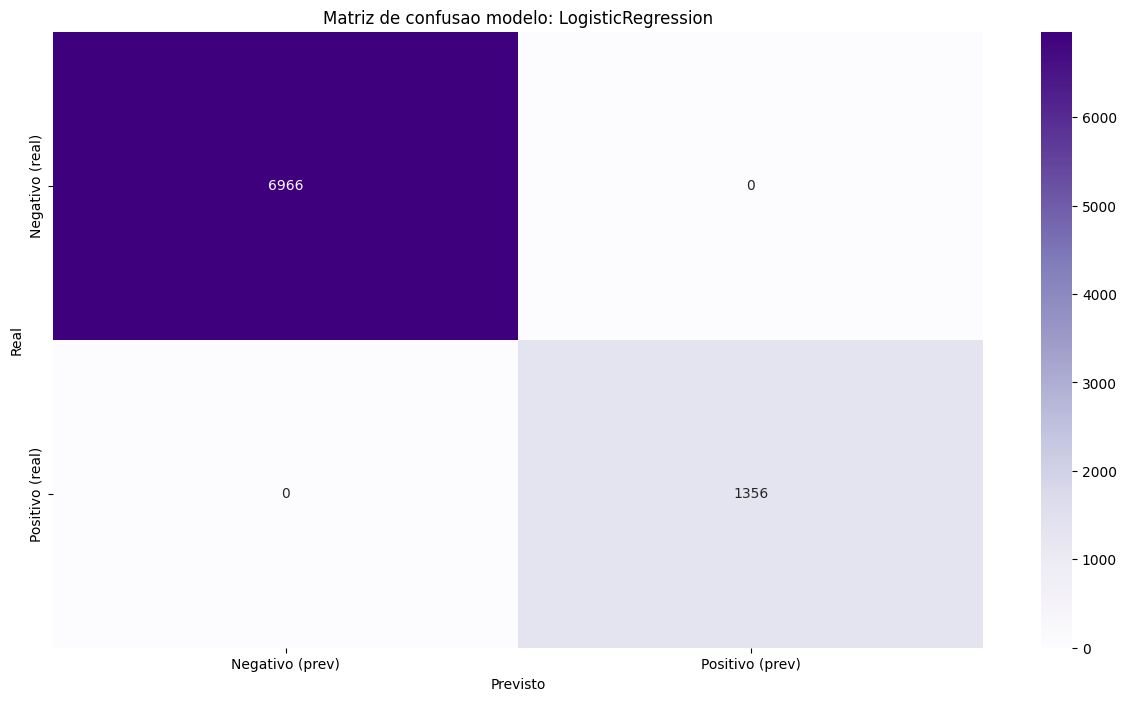

treinando modelo: DecisionTreeClassifier


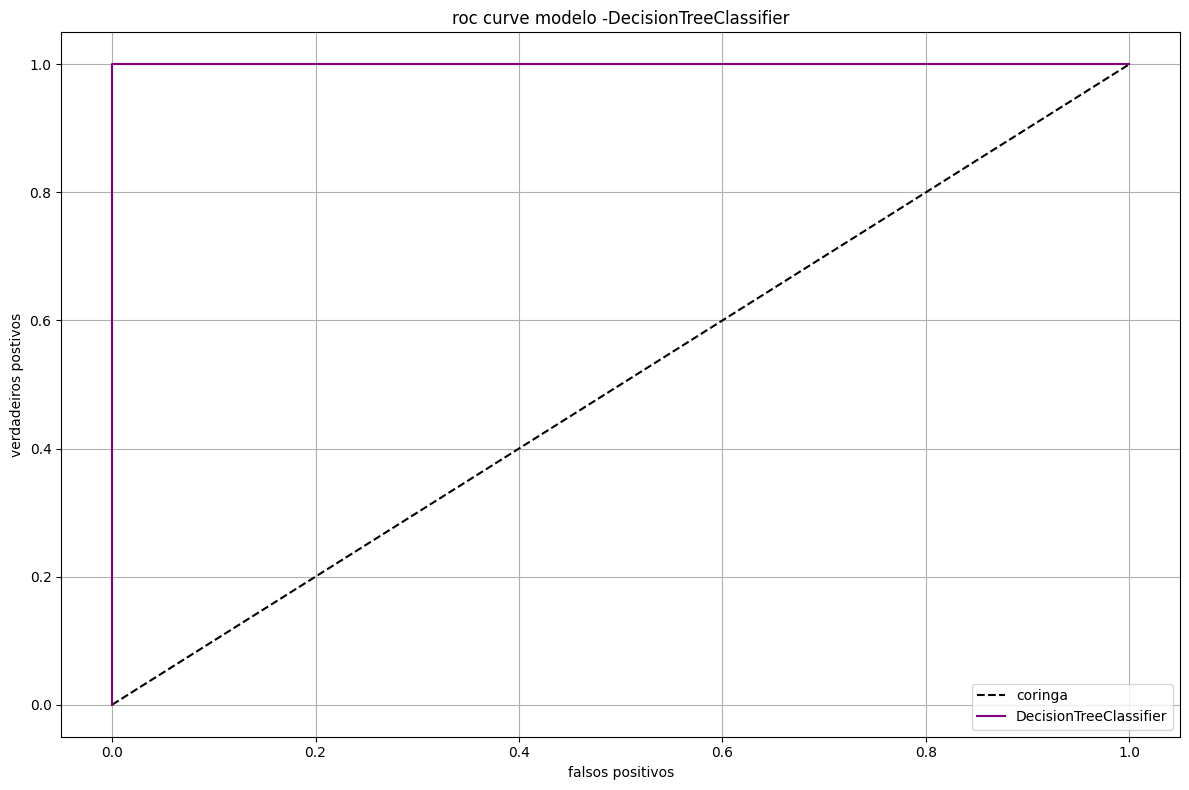

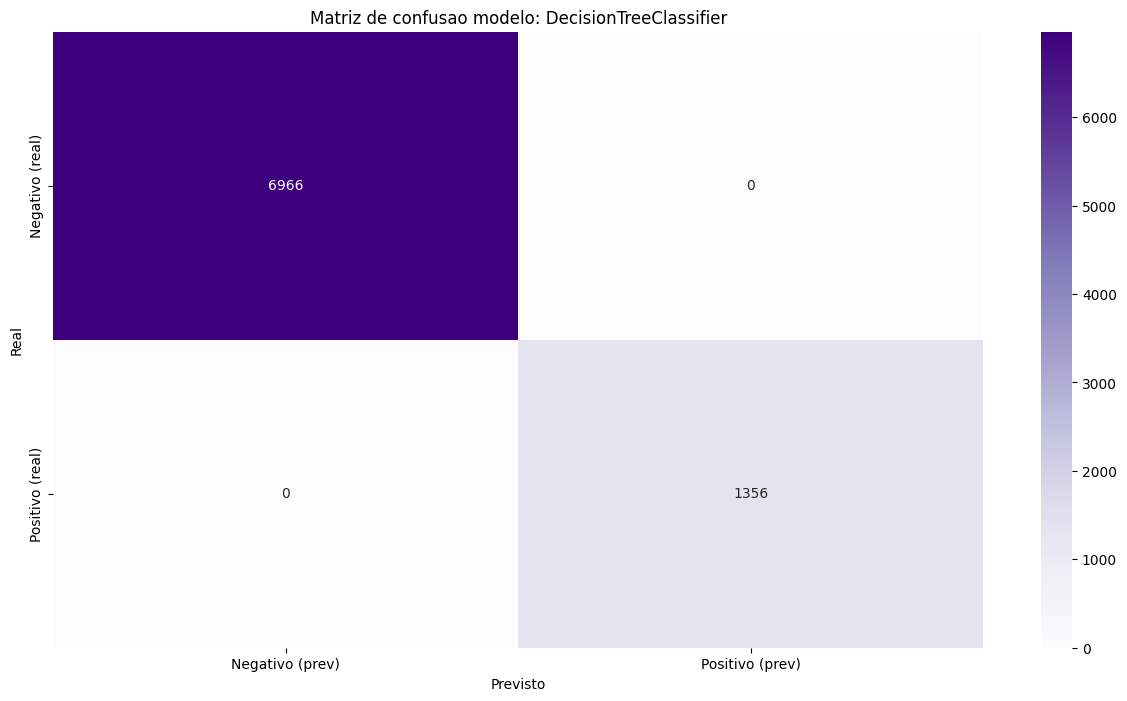

treinando modelo: XGBClassifier


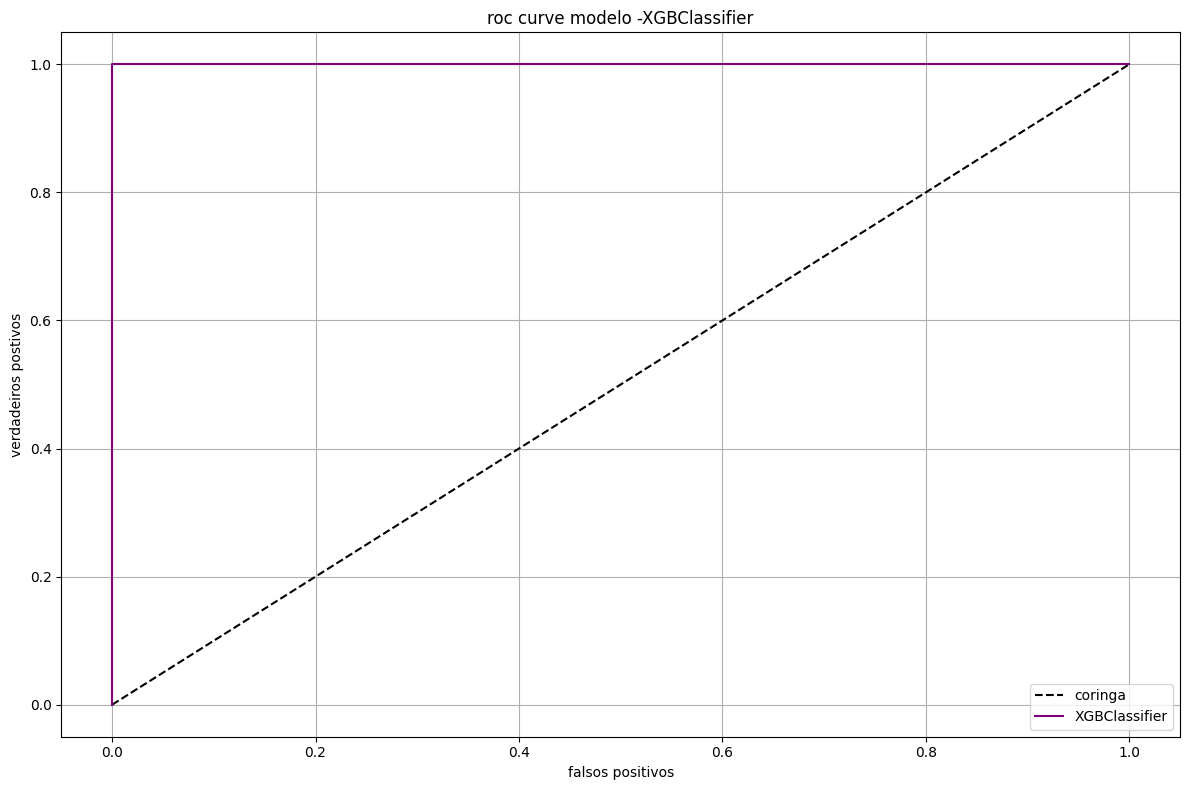

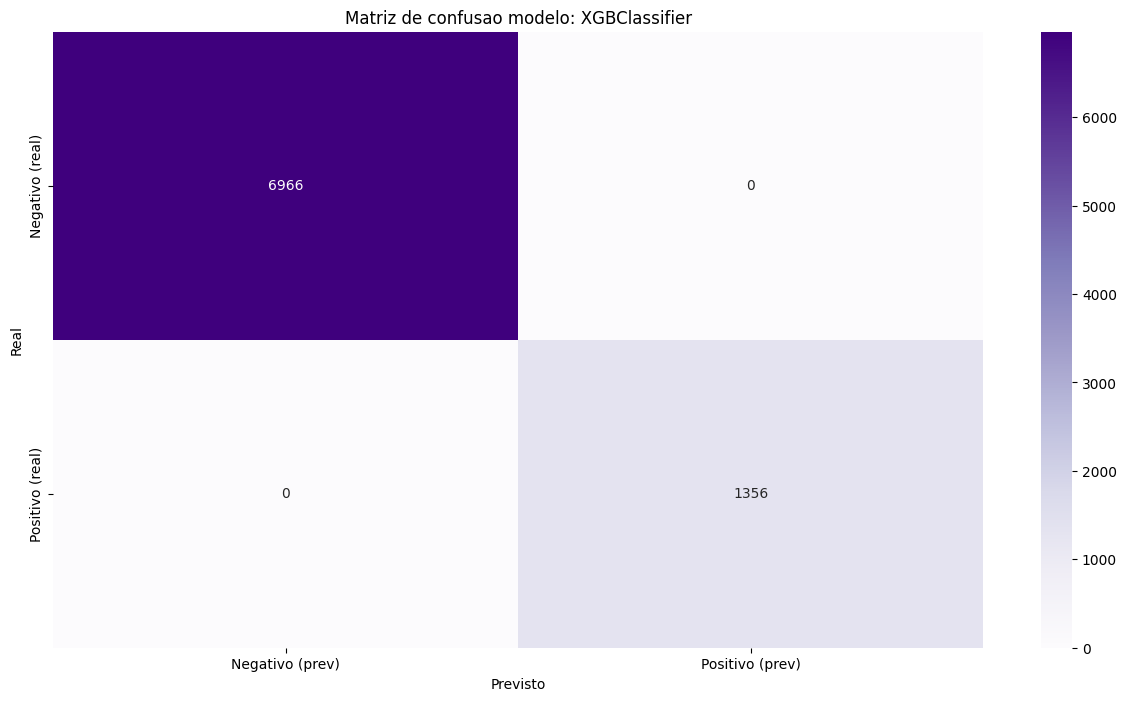

======== Metricas ========


,0,1,2
model_name,LogisticRegression,DecisionTreeClassifier,XGBClassifier
acuracia,1.0,1.0,1.0
precisao,1.0,1.0,1.0
f1_score,1.0,1.0,1.0
recall,1.0,1.0,1.0
roc_auc,1.0,1.0,1.0


In [58]:
# laço para treino/avaliacao e plot de curvas 
metrics_list = []
for i, model in models.items():
    print(f'treinando modelo: {model.__class__.__name__}')
    pipe.set_params(model=model).fit(x_train, y_train)
    
    # avaliando 
    y_pred = pipe.predict(x_test)
    y_proba = pipe.predict_proba(x_test)[:,1]
    metrics_ = metrics(model, y_test, y_pred)
    metrics_list.append(metrics_)
    roc_curve_plot(model=model, y_true=y_test, y_proba=y_proba)
    
    # matriz de confusao 
    matrix(model=model, y_true=y_test, y_pred=y_pred)
print('======== Metricas ========')
df_metrics = pd.DataFrame(metrics_list)
display(df_metrics.T)

Todos os modelos ficaram com suas metricas perfeitas, que pode ser um problema devido ao overfitting. Irei avalia-los agora utilizando cross validate

Cross validate

In [73]:
cross_list = []
for i, cross in models.items():
    estimator = pipe.set_params(model=cross)
    val_cross = cross_validate(estimator=estimator, X=x, y=y, scoring='recall', cv=10)
    
    # saida do cross validate
    out_cross = {
        'model':cross.__class__.__name__,
        'min':min(val_cross['test_score']),
        'mean':np.mean(val_cross['test_score']),
        'max':max(val_cross['test_score']),
        'std': np.std(val_cross['test_score'])
    }
    cross_list.append(out_cross)
df_cross = pd.DataFrame(cross_list)
display(df_cross)

,model,min,mean,max,std
0,LogisticRegression,1.000000,1.000000,1.0,0.000000
1,DecisionTreeClassifier,1.000000,1.000000,1.0,0.000000
2,XGBClassifier,0.998494,0.999849,1.0,0.000452
